<a href="https://colab.research.google.com/github/henriquehorton/Python_aprendendo/blob/master/agoritmo_deteccao_ptx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O algoritmo terá a seguinte o seguinte fluxograma:

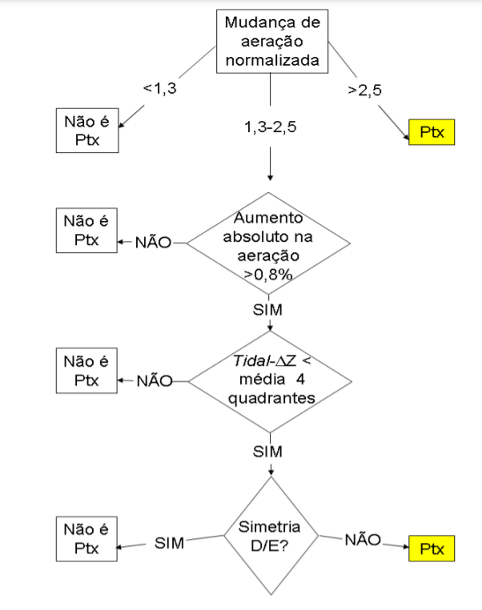

Explicar cada uns dos elementos do fluxograma (Decisões e Ações)

##Conectar ao goole driver

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Mandar scripts para diretorio raiz

In [2]:
!cp /content/drive/MyDrive/UFABC/IC/ptx_detect/utils_txt_vol.py /content/

## Importando bibliotecas

In [3]:
import bz2
import pickle
import matplotlib.pyplot as plt
import utils_txt_vol as txt
from scipy.signal import sosfiltfilt, butter
import numpy as np

In [4]:
# Permite não ter que reiniciar o kernel para testar mudanças nos arquivos *.py
%load_ext autoreload
%autoreload 2

## Lendo arquivo

In [5]:
nome = '/content/drive/MyDrive/UFABC/IC/ptx_detect/dados/ptx2.bz2' # Caminho do drive (colab)
# nome = 'dados/ptx2.bz2'
infile = bz2.BZ2File(nome, 'rb')
data = pickle.load(infile)
infile.close()

In [6]:
def data_filter(data, order = 8, fs = 3):
    # butter(ordem, freq_corte)
    sos = butter(order, fs, output='sos', fs=50)
    for idx in range(1024):
        data.vol[:,idx] = sosfiltfilt(sos, data.vol[:,idx])
    data.plets = [ np.sum(x) for x in data.vol]
    return data

In [7]:
data_filtrado = txt.data_copy(data)
data_filtrado = data_filter(data_filtrado, fs=2)

In [8]:
ins_marks = [idx for idx,x in enumerate(data.ins_mark) if x != 0]
exp_marks = [idx for idx,x in enumerate(data.exp_mark) if x != 0]

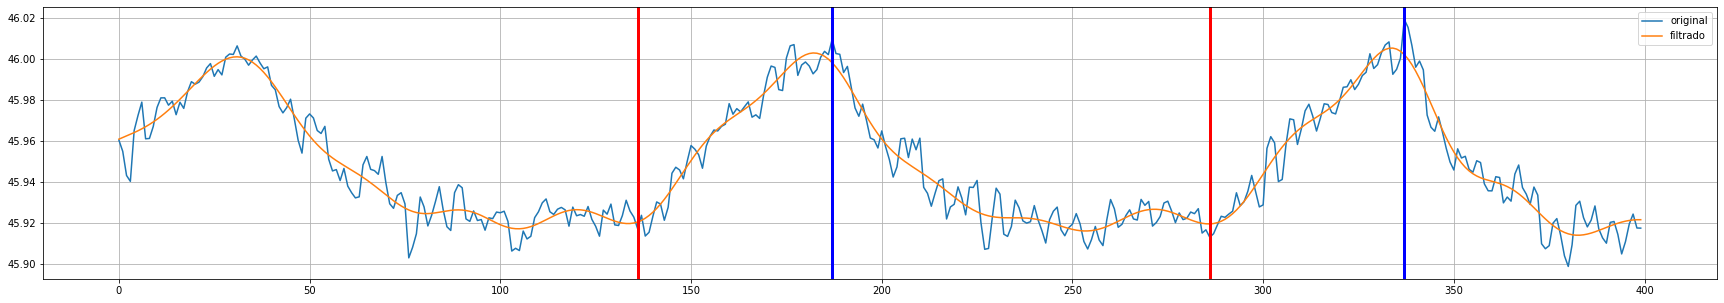

In [151]:
numbers_frames = 400
plt.figure(figsize=(30,5))
plt.plot(data.plets[:numbers_frames],label='original')
plt.plot(data_filtrado.plets[:numbers_frames],label='filtrado')
for i in ins_marks:
  if i <= numbers_frames:
    plt.gca().axvline(x=i, color = "red",linewidth=3)
for e in exp_marks:
  if e <= numbers_frames:
    plt.gca().axvline(x=e, color = "blue",linewidth=3)
plt.grid()
plt.legend()
plt.show()

##Carregando imagens

In [10]:
dir_matrizes_sem_atlas = '/content/drive/MyDrive/UFABC/IC/ptx_detect/matrizes/sem_atlas/Pig_0/' # sem atlas #Caminho do drive (colab)
# dir_matrizes_sem_atlas = 'matrizes/sem_atlas/Pig_0/' # sem atlas

In [11]:
wien = txt.my_wiener(dir_matrizes_sem_atlas)

In [12]:
wien.load_data(data)

##Mudança de Aeração Normalizada

In [13]:
import pandas as pd

In [67]:
# df = pd.DataFrame({"Plets": (data.plets),
#               "Mark ins": data.ins_mark,
#               "Mark exp": data.exp_mark})
# df.index = np.arange(1, len(df)+1)

Cada Frame do pulmão será dividida em 4 quadrantes Iguais que serão identificadas pelas seguintes variáveis:

Q1: Superior Direito - [ :16, :16]

Q2: Superior Esquerdo - [ :16,16: ]

Q3: Inferior Direito - [16: , :16]

Q4: Inferior Esquerdo - [16: ,16: ]

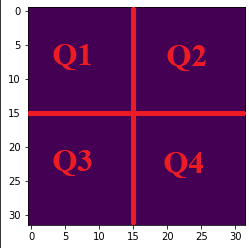

No Frame 136 foi encontrado um possivel pneumotórax.
Valores de Aumento de aeração absoluta:
 Q1 = -0.0 
 Q2 = -0.328736046894988 
 Q3 = -6.605566259490347 
 Q4 = -1.3005911310398428
------------------------------------------------------------------------------------------
No Frame 286 foi encontrado um possivel pneumotórax.
Valores de Aumento de aeração absoluta:
 Q1 = 0.03456908627752972 
 Q2 = -0.2685319684874404 
 Q3 = -6.6172714519147044 
 Q4 = -1.2632301414668363
------------------------------------------------------------------------------------------
No Frame 436 foi encontrado um possivel pneumotórax.
Valores de Aumento de aeração absoluta:
 Q1 = 0.009981679737388506 
 Q2 = -0.22818562851822635 
 Q3 = -6.493500869758135 
 Q4 = -1.289764569823136
------------------------------------------------------------------------------------------
No Frame 585 foi encontrado um possivel pneumotórax.
Valores de Aumento de aeração absoluta:
 Q1 = 0.05828235301096353 
 Q2 = -0.332517865161450

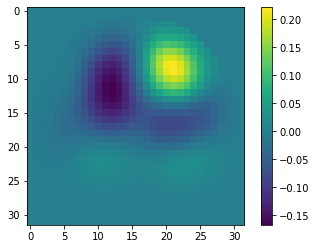

In [177]:
frame_ptx = None
quad_ptx = None
count = 0
 #1 *********Aqui começa a mudança de aeração normalizada*********

''' Foi feita a divião da média de cada quadrante pela média da imagem inteira 
'''
 
for i in ins_marks:
  count += 1
  image = wien.get_image32(i).mean()
  q1 = wien.get_image32(i)[:16,:16].mean()/image
  q2 = wien.get_image32(i)[:16,16:].mean()/image
  q3 = wien.get_image32(i)[16:,:16].mean()/image
  q4 = wien.get_image32(i)[16:,16:].mean()/image
  
  if q1 >2.5:
    quad_ptx = 1
  elif q2 > 2.5:
    quad_ptx = 2
  elif q3 > 2.5:
    quad_ptx = 3
  elif q4 >2.5:
    quad_ptx = 4

  if (q1 or q2 or q3 or q4) >2.5:
    frame_ptx = i
    print('No Frame {} foi encontrado um pneumotórax localizado no quadrante: {}'.format(frame_ptx, quad_ptx))
    print('Valores de mudança de aeração por quadrante:\n Q1 = {} \n Q2 = {} \n Q3 = {} \n Q4 = {}' .format(q1,q2,q3,q4))
    plt.imshow(wien.get_image32(frame_ptx))
    plt.colorbar()
    break
  elif (q1 or q2 or q3 or q4) >=1.3 or (q1 or q2 or q3 or q4) <=2.5:
    
    #2 ********* Aqui começa a aumento absoluto da aeração *************

    frame_ptx = i
    aumento_abs_q1 = (wien.get_image32(i)[:16,:16].sum()-wien.get_image32(ins_marks[0])[:16,:16].sum())/wien.get_image32(ins_marks[0])[:16,:16].sum()
    aumento_abs_q2 = (wien.get_image32(i)[:16,16:].sum()-wien.get_image32(ins_marks[0])[:16,:16].sum())/wien.get_image32(ins_marks[0])[:16,16:].sum()
    aumento_abs_q3 = (wien.get_image32(i)[16:,:16].sum()-wien.get_image32(ins_marks[0])[:16,:16].sum())/wien.get_image32(ins_marks[0])[16:,:16].sum()
    aumento_abs_q4 = (wien.get_image32(i)[16:,16:].sum()-wien.get_image32(ins_marks[0])[:16,:16].sum())/wien.get_image32(ins_marks[0])[16:,16:].sum()
    print('No Frame {} foi encontrado um possivel pneumotórax.'.format(frame_ptx))
    print('Valores de Aumento de aeração absoluta:\n Q1 = {} \n Q2 = {} \n Q3 = {} \n Q4 = {}' 
          .format(aumento_abs_q1,aumento_abs_q2,aumento_abs_q3,aumento_abs_q4))
    print('------------------------------------------------------------------------------------------')

    #2 ********* Aqui termina a aumento absoluto da aeração *************

    #1 *********Aqui termina a mudança de aeração normalizada*********